In [ ]:
'''
Extractive QA : two step process where first retrieving relevant documents and then extracting answers from them is also
the basis for many modern QA systems, including semantic search engines, intelligent assistants, and automated information extractors.

Community QA : involves gathering question-answer pairs that are generated by users on forums like Stack Overflow, and then using semantic similarity
search to find the closest matching answer to a new question

Long-form QA : aims to generated long pragraph complex answers to open ended questions like "Why sky is bule?" etc...

We are try to build  a QA systems using SubjQA dataset

SubjQA Dataset : Dataset build on customer reviews on various products spanning 6 categories like Trip-Advisior, Restraunts, Books, Movies, Electronics and Grocery
  - most QA are subjective  as they depend on user personal experience..

QA Systems can also be categorized based on domain of data that they access for responding a query
  Closed Domain : where the domain data is limited and related only to single product or category
  Open Domain   : where the domain data is large and can be treated as having access whole prodcut catalogue

'''

In [ ]:
!pip install transformers
!pip install accelerate -U


# SubjQA Dataset

In [1]:
from datasets import get_dataset_config_names
from datasets import load_dataset

import pandas as pd
import matplotlib.pyplot as plt
import torch


from transformers import AutoTokenizer
from transformers import AutoModelForQuestionAnswering
from transformers import pipeline

In [2]:
domains = get_dataset_config_names("subjqa")

print(domains)

['books', 'electronics', 'grocery', 'movies', 'restaurants', 'tripadvisor']


In [3]:
subjqa  = load_dataset("subjqa",name = 'electronics')

In [4]:
print(subjqa['train']['answers'][1])

{'text': ['Bass is weak as expected', 'Bass is weak as expected, even with EQ adjusted up'], 'answer_start': [1302, 1302], 'answer_subj_level': [1, 1], 'ans_subj_score': [0.5083333253860474, 0.5083333253860474], 'is_ans_subjective': [True, True]}


In [5]:
#flatten the dataset to dataframe to understand it more better.....
dfs = {split : dset.to_pandas() for split,dset in subjqa.flatten().items()}

for split,df in dfs.items():
    print(f"Number of Questions in {split} : {df['id'].nunique()}")

Number of Questions in train : 1295
Number of Questions in test : 358
Number of Questions in validation : 255


'''Column name Description\n

title                 :The Amazon Standard Identification Number (ASIN) associated with each product\n
question              :The question\n
answers.answer_text   :The span of text in the review labeled by the annotator\n
answers.answer_start  :The start character index of the answer span\n
context               :The customer review\n
'''



In [6]:
#viewing samples of dataset......
qa_cols = ['title','question','answers.text','answers.answer_start','context']

sample_df = dfs['train'][qa_cols].sample(2,random_state=7)
sample_df

,title,question,answers.text,answers.answer_start,context
791,B005DKZTMG,Does the keyboard lightweight?,[this keyboard is compact],[215],I really like this keyboard. I give it 4 star...
1159,B00AAIPT76,How is the battery?,[],[],I bought this after the first spare gopro batt...


In [7]:
'''Empty values in answers.text column denotes question cannot be answerable from given user review'''

start_idx = sample_df["answers.answer_start"].iloc[0][0]
end_idx = start_idx + len(sample_df["answers.text"].iloc[0][0])
sample_df["context"].iloc[0][start_idx:end_idx]

'this keyboard is compact'

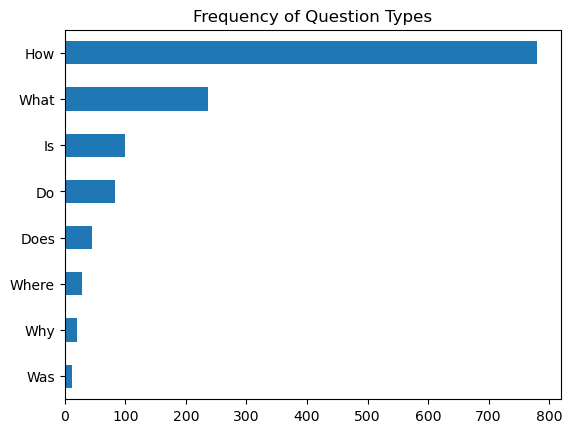

In [8]:
#counts of questions starting with majority of question words....
counts = {}
question_types = ["What", "How", "Is", "Does", "Do", "Was", "Where", "Why"]

for q in question_types:
  counts[q] = dfs["train"]["question"].str.startswith(q).value_counts()[True]

pd.Series(counts).sort_values().plot.barh()
plt.title("Frequency of Question Types")
plt.show()

In [9]:
#printing most repeated questions...
for question_type in ["How", "What", "Is"]:
    for question in (dfs["train"][dfs["train"].question.str.startswith(question_type)].sample(n=3, random_state=42)['question']):
        print(question)

How is the camera?
How do you like the control?
How fast is the charger?
What is direction?
What is the quality of the construction of the bag?
What is your impression of the product?
Is this how zoom works?
Is sound clear?
Is it a wireless keyboard?


# Tokenization of text for QA

In [10]:
model_ckpt = "deepset/minilm-uncased-squad2"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

In [11]:
#In extractive QA tasks the input is provided as (question,context) where answer is extracted from context...
question = "How much music can this hold?"
context = """An MP3 is about 1 MB/minute, so about 6000 hours depending on file size."""
inputs = tokenizer(question, context, return_tensors="pt")

#the token_type_ids : 0 for question and 1 for context.. [SEP] token is used to seperate question and context...
print(tokenizer.decode(inputs["input_ids"][0]))

[CLS] how much music can this hold? [SEP] an mp3 is about 1 mb / minute, so about 6000 hours depending on file size. [SEP]


In [12]:
#instantiating model....
model = AutoModelForQuestionAnswering.from_pretrained(model_ckpt)

Some weights of the model checkpoint at deepset/minilm-uncased-squad2 were not used when initializing BertForQuestionAnswering: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing BertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [13]:
#generating output for current input QA....
with torch.no_grad():
    outputs = model(**inputs)
    
print(outputs)

QuestionAnsweringModelOutput(loss=None, start_logits=tensor([[-0.9862, -4.7750, -5.4025, -5.2378, -5.2863, -5.5117, -4.9819, -6.1880,
         -0.9862,  0.2596, -0.2144, -1.7136,  3.7806,  4.8561, -1.0546, -3.9097,
         -1.7374, -4.5944, -1.4278,  3.9949,  5.0391, -0.2018, -3.0193, -4.8549,
         -2.3108, -3.5110, -3.5713, -0.9862]]), end_logits=tensor([[-0.9623, -5.4733, -5.0326, -5.1639, -5.4278, -5.5151, -5.1749, -4.6233,
         -0.9623, -3.7855, -0.8715, -3.7745, -3.0161, -1.1780,  0.1758, -2.7365,
          4.8934,  0.3046, -3.1761, -3.2762,  0.8937,  5.6606, -0.3623, -4.9554,
         -3.2531, -0.0914,  1.6211, -0.9623]]), hidden_states=None, attentions=None)


In [14]:
#the output contains the start logits and end logits, the we have to find the start id and end id
#to know span of the answer from context
start_logit = outputs.start_logits
end_logit   = outputs.end_logits

#comparing the shpae of input and logits.....
print(f"Input IDs shape: {inputs.input_ids.size()}")
print(f"Start logits shape: {start_logit.size()}")
print(f"End logits shape: {end_logit.size()}")


Input IDs shape: torch.Size([1, 28])
Start logits shape: torch.Size([1, 28])
End logits shape: torch.Size([1, 28])


In [15]:
#finding span of answer.....
start_idx = torch.argmax(start_logit)
end_idx   = torch.argmax(end_logit) + 1

answer_span = inputs['input_ids'][0][start_idx:end_idx]

answer = tokenizer.decode(answer_span)
print(f"Question : {question}")
print(f"Answer   : {answer}")


Question : How much music can this hold?
Answer   : 6000 hours


In [16]:
#above process can be just build as single pipeline using pipeline....
pipe = pipeline("question-answering",model = model, tokenizer = tokenizer)
pipe(question=question,context=context,top_k=3)

[{'score': 0.2651614844799042, 'start': 38, 'end': 48, 'answer': '6000 hours'},
 {'score': 0.22082971036434174,
  'start': 16,
  'end': 48,
  'answer': '1 MB/minute, so about 6000 hours'},
 {'score': 0.10253533720970154,
  'start': 16,
  'end': 27,
  'answer': '1 MB/minute'}]

In [17]:
#case where there is no context to answer the question.....
pipe(question="Why is there no data?", context=context,handle_impossible_answer=True)

{'score': 0.9068413376808167, 'start': 0, 'end': 0, 'answer': ''}

In [18]:
#For context lenght > max seq_len of model, sliding window can be used where the context get adjusted by sliding over context based on window size.

#example of sliding window technique in transformers using tokenizer...
example = dfs["train"].iloc[0][["question", "context"]]

tokenized_example = tokenizer(example["question"], example["context"],return_overflowing_tokens=True, max_length=100,stride=25,truncation=True)

In [19]:
for idx, window in enumerate(tokenized_example["input_ids"]):
    print(f"Window #{idx} has {len(window)} tokens")

Window #0 has 100 tokens
Window #1 has 88 tokens


In [20]:
for window in tokenized_example["input_ids"]:
    print(f"{tokenizer.decode(window)} \n")

[CLS] how is the bass? [SEP] i have had koss headphones in the past, pro 4aa and qz - 99. the koss portapro is portable and has great bass response. the work great with my android phone and can be " rolled up " to be carried in my motorcycle jacket or computer bag without getting crunched. they are very light and do not feel heavy or bear down on your ears even after listening to music with them on all day. the sound is [SEP] 

[CLS] how is the bass? [SEP] and do not feel heavy or bear down on your ears even after listening to music with them on all day. the sound is night and day better than any ear - bud could be and are almost as good as the pro 4aa. they are " open air " headphones so you cannot match the bass to the sealed types, but it comes close. for $ 32, you cannot go wrong. [SEP] 



# Building a QA retriever system using Elastic Search and Haystack



Elastic Search is type of database where we can store documents based on indexes......

Haystack can be used to build end to end QA retrival system. We can use it to build, it has two components

   Retreiver : It is responsible to retreiving documents related to query
                - retreival process can be two types like sparse and dense
                where the sparse : method focus on extracting queries based on freq. of words
                -dense : uses embeddings generated from models and then semantic search to extract related doc based on query
                
   Reader  : responsible for extracting answer from documents provied by the retriever
   
 - These two are the building blocks of the Haystack pipeline
 Along with these bolcks we should also require Document Store and pipeline
 Document Store : It is used to store the documents and create database along with metadata
 Pipeline       : It combines both retriver and reader into single system where user interacts by asking multiple queries

In [21]:
from haystack.document_stores import ElasticsearchDocumentStore #initializing document store...
from haystack.nodes import BM25Retriever #initializing a retriever.....
from haystack.nodes import FARMReader #initializing a reader.....
from haystack.nodes import DensePassageRetriever #dense retriever...
from haystack import Label,Document,Answer,Span,MultiLabel #tools for creating labels....
from haystack import Pipeline #creating a pipeline....
from haystack.utils import print_answers #utility to print answers

In [22]:
#creating a connection between elasticsearch and creating a document store
document_store = ElasticsearchDocumentStore(host='localhost',port = '9200',username='elastic',password='L+NJ7i*=wlNYheMHQWfe',index='document')

This ElasticsearchDocumentStore has been built for Elasticsearch 7, but the detected version of the Elasticsearch server is 8.3.1. Unexpected behaviors or errors may occur due to version incompatibility.


In [23]:
#adding data to the document store.......
'''
format of adding data to store is 
         {"context" : 'main data we interested to add'
          "meta" : "{dict of all meta information we are interested to add}"}
          '''

for split, df in dfs.items():
    # Exclude duplicate reviews
    docs = [{"content": row["context"],"meta":{"item_id": row["title"], "question_id": row["id"],"split": split}}
    for _,row in df.drop_duplicates(subset="context").iterrows()]
    
    document_store.write_documents(docs, index="document")
    
print(f"Loaded {document_store.get_document_count()} documents")

Loaded 1615 documents


In [24]:
#initializing a document retriever accordingly......
sparse_retriever = BM25Retriever(document_store=document_store)

In [25]:
#trying to fetch a record based on question and meta data...
item_id = "B0074BW614"
query = "Is it good for reading?"
retrieved_docs = sparse_retriever.retrieve(query=query, top_k=3, filters={"item_id":[item_id], "split":["train"]})

In [26]:
retrieved_docs[0]

<Document: {'content': 'This is a gift to myself.  I have been a kindle user for 4 years and this is my third one.  I never thought I would want a fire for I mainly use it for book reading.  I decided to try the fire for when I travel I take my laptop, my phone and my iPod classic.  I love my iPod but watching movies on the plane with it can be challenging because it is so small. Laptops battery life is not as good as the Kindle.  So the Fire combines for me what I needed all three to do. So far so good.', 'content_type': 'text', 'score': 0.6856682061761326, 'meta': {'split': 'train', 'item_id': 'B0074BW614', 'question_id': '868e311275e26dbafe5af70774a300f3'}, 'id_hash_keys': ['content'], 'embedding': None, 'id': '252e83e25d52df7311d597dc89eef9f6'}>

In [27]:
#initializing a reader.....

model_ckpt = "deepset/minilm-uncased-squad2" #model name we are intreseted to generate embeddings....

max_seq_length, doc_stride = 384, 128 #


reader = FARMReader(model_name_or_path=model_ckpt, 
                    progress_bar=False,
                    max_seq_len=max_seq_length, 
                    doc_stride=doc_stride,
                    return_no_answer=True)

Some weights of the model checkpoint at deepset/minilm-uncased-squad2 were not used when initializing BertForQuestionAnswering: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing BertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [28]:
print(reader.predict_on_texts(question=question, texts=[context], top_k=1))

{'query': 'How much music can this hold?', 'no_ans_gap': 12.64808738231659, 'answers': [<Answer {'answer': '6000 hours', 'type': 'extractive', 'score': 0.5293055772781372, 'context': 'An MP3 is about 1 MB/minute, so about 6000 hours depending on file size.', 'offsets_in_document': [{'start': 38, 'end': 48}], 'offsets_in_context': [{'start': 38, 'end': 48}], 'document_ids': ['e344757014e804eff50faa3ecf1c9c75'], 'meta': {}}>]}


In [29]:
#BM@%retriever pipeline.....
querying_pipeline = Pipeline()
querying_pipeline.add_node(component=sparse_retriever, name="Retriever", inputs=["Query"])
querying_pipeline.add_node(component=reader, name="Reader", inputs=["Retriever"])

In [30]:
n_answers = 3
preds = querying_pipeline.run(query=query,
                              params = {"Retriever" : {"top_k": 3}, 'Reader' : {"top_k" : 3}})
print(f"Question: {preds['query']} \n")

Question: Is it good for reading? 



In [31]:
print_answers(preds, details="minimum")

'Query: Is it good for reading?'
'Answers:'
[   {   'answer': 'This is a good tablet for reading books',
        'context': ' I expect of a tablet.The text is very clear and sharp. '
                   'This is a good tablet for reading books, which is more '
                   'than I expected.There is the one small '},
    {   'answer': 'it is great for reading books when no light is available',
        'context': 'ecoming addicted to hers! Our son LOVES it and it is great '
                   'for reading books when no light is available. Amazing '
                   'sound but I suggest good headphones t'},
    {   'answer': 'I mainly use it for book reading',
        'context': ' is my third one.  I never thought I would want a fire for '
                   'I mainly use it for book reading.  I decided to try the '
                   'fire for when I travel I take my la'}]


In [32]:
#we can convert answer to dict
preds['answers'][0].to_dict()

{'answer': 'This is a good tablet for reading books',
 'type': 'extractive',
 'score': 0.6662688851356506,
 'context': ' I expect of a tablet.The text is very clear and sharp. This is a good tablet for reading books, which is more than I expected.There is the one small ',
 'offsets_in_document': [{'start': 196, 'end': 235}],
 'offsets_in_context': [{'start': 56, 'end': 95}],
 'document_ids': ['12816e24def1d783b8fca3fbd7cb28a1'],
 'meta': {'split': 'train',
  'item_id': 'B00DVFLJDS',
  'question_id': 'f9a7e7eb40501bf4a2bda84799f6fdd0'}}

## Evaluating QA pipeline


In [33]:
#Evalating the performance of the retriever.....
'''
For evalating the retriever we use "recall" as metric i.e we will count number of documents that contain answer
for given question from retrieved top_k documents...
 
This can be acheived by using custom pipeline evalation metric class
'''
class PipelineNode:
    
    def __init__(self):
        self.outgoing_edges = 1
        
        
    def run(self,**kwargs):
        return (outputs,"outgoing_edge_name")


In [35]:
#creating labels for the dataset...
labels = []
f_labels = []
for i, row in dfs["test"].iterrows():
    
    # Metadata used for filtering in the Retriever
    meta = {"item_id": row["title"], "question_id": row["id"]}
    
    # Populate labels for questions with answers
    if len(row["answers.text"]):
        for idx,answer in enumerate(row["answers.text"]):
            
            span_start = row["answers.answer_start"][idx]
            span_end   = span_start + len(answer)
            
            label = Label(query = row["question"],
                          answer= Answer(answer=answer,offsets_in_context =[ Span(span_start,span_end)]),
                          
                          document = Document(id = i,
                                             content_type="text",
                                             content = row['context']),
                          origin="gold-label",
                          meta=meta,
                          is_correct_answer=True,
                          is_correct_document=True,
                          no_answer=False)
                          
    
            labels.append(label)
    # Populate labels for questions without answers
    else:
        
        label = Label(
            query=row["question"],
            answer=Answer(answer=""),
            document=Document(
                id=i,
                content_type="text",
                content=row["context"]
            ),
            origin="gold-label",
            meta=meta,
            is_correct_answer=True,
            is_correct_document=True,
            no_answer=True)
        
        labels.append(label)

In [37]:
document_store.write_labels(labels=labels,index="labels")
print(f"""Loaded {document_store.get_label_count(index="labels")} question-answer pairs""")

Loaded 455 question-answer pairs


In [38]:
labels_agg = document_store.get_all_labels_aggregated(index="labels",open_domain=True,aggregate_by_meta=["item_id"])
print(len(labels_agg))

330


In [39]:
print(labels_agg[109])

<MultiLabel: {'labels': [{'id': '7cb589cc-ff9c-4ceb-aaca-1e59f16b1122', 'query': 'How does the fan work?', 'document': {'id': '112', 'content': 'the usb on the back caused my mac to restart when i would plug something into about 50% of the time.  very annoying but the fan is really really good!', 'content_type': 'text', 'meta': {}, 'id_hash_keys': ['content'], 'score': None, 'embedding': None}, 'is_correct_answer': True, 'is_correct_document': True, 'origin': 'gold-label', 'answer': {'answer': 'the fan is really really good', 'type': 'extractive', 'score': None, 'context': None, 'offsets_in_document': None, 'offsets_in_context': [{'start': 120, 'end': 149}], 'document_ids': None, 'meta': {}}, 'pipeline_id': None, 'created_at': '2023-10-21 12:05:10', 'updated_at': '2023-10-21 12:05:10', 'meta': {'item_id': 'B002MU1ZRS', 'question_id': '5a9b7616541f700f103d21f8ad41bc4b'}, 'filters': {'item_id': ['B002MU1ZRS']}}, {'id': 'a9b4698c-9856-467c-9211-1183e3b64345', 'query': 'How does the fan wo

In [40]:
eval_result = querying_pipeline.eval(labels=labels_agg, params={"Retriever": {"top_k": 3}})

In [41]:
metrics = eval_result.calculate_metrics()

print(f'Retriever - Recall (single relevant document): {metrics["Retriever"]["recall_single_hit"]}')
print(f'Retriever - Recall (multiple relevant documents): {metrics["Retriever"]["recall_multi_hit"]}')
print(f'Retriever - Mean Reciprocal Rank: {metrics["Retriever"]["mrr"]}')
print(f'Retriever - Precision: {metrics["Retriever"]["precision"]}')
print(f'Retriever - Mean Average Precision: {metrics["Retriever"]["map"]}')
print(f'Reader - F1-Score: {metrics["Reader"]["f1"]}')
print(f'Reader - Exact Match: {metrics["Reader"]["exact_match"]}')

Retriever - Recall (single relevant document): 0.896969696969697
Retriever - Recall (multiple relevant documents): 0.8911616161616162
Retriever - Mean Reciprocal Rank: 0.8368686868686868
Retriever - Precision: 0.7439393939393939
Retriever - Mean Average Precision: 0.8328282828282828
Reader - F1-Score: 0.6870027922482301
Reader - Exact Match: 0.5696969696969697


In [42]:
def eval_retriever(pipe,labels_agg):
    topk_results = {}
    for k in [1,3,5,10,20]:
        eval_ = pipe.eval(labels=labels_agg, params={"Retriever": {"top_k": k}})
        metrics_   = eval_.calculate_metrics()
        topk_results[k] = {"recall_single" : metrics_['Retriever']['recall_single_hit'],
                          "recall_multi"   : metrics_['Retriever']['recall_multi_hit']}

    return pd.DataFrame.from_dict(topk_results,orient='index')

In [43]:
topk_df = eval_retriever(querying_pipeline,labels_agg)
topk_df

,recall_single,recall_multi
1,0.790909,0.781818
3,0.896970,0.891162
5,0.924242,0.922727
10,0.960606,0.959091
20,0.987879,0.986364


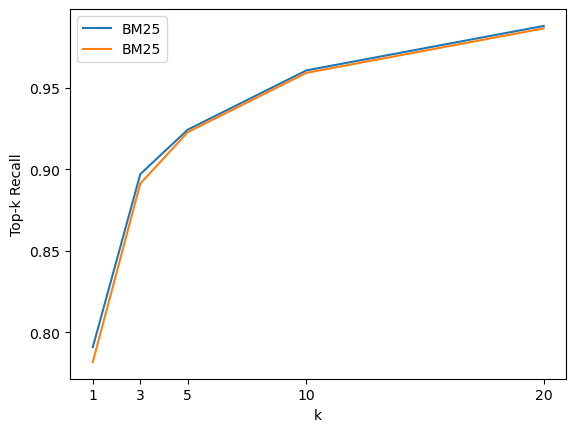

In [44]:
#method to plot recall from dataset.....
def plot_retriever_eval(dfs, retriever_names):
    fig, ax = plt.subplots()
    for df, retriever_name in zip(dfs, retriever_names):
        df.plot(y="recall_single", ax=ax, label=retriever_name)
        df.plot(y="recall_multi",ax=ax,label=retriever_name)
    plt.xticks(df.index)
    plt.ylabel("Top-k Recall")
    plt.xlabel("k")
    plt.show()
    
plot_retriever_eval([topk_df], ["BM25"])

In [46]:
dpr_retriever = DensePassageRetriever(document_store=document_store,
query_embedding_model="facebook/dpr-question_encoder-single-nq-base",
passage_embedding_model="facebook/dpr-ctx_encoder-single-nq-base",embed_title=False)

D:\Conda3\Lib\site-packages\torch\_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


In [48]:
document_store.update_embeddings(dpr_retriever)

Create embeddings:  63%|███████████████████████████████████▍                    | 1024/1616 [09:32<05:01,  1.96 Docs/s]


Create embeddings: 100%|████████████████████████████████████████████████████████| 1616/1616 [15:23<00:00,  1.36s/ Docs]
Updating embeddings: 10000 Docs [15:42, 10.62 Docs/s]                                                                  


In [49]:
#desnse_pipeline
dense_pipeline = Pipeline()
dense_pipeline.add_node(component=dpr_retriever, name="Retriever", inputs=["Query"])
dense_pipeline.add_node(component=reader, name="Reader", inputs=["Retriever"])

In [55]:
eval_result = dense_pipeline.eval(labels=labels_agg, params={"Retriever": {"top_k": 3}})

In [45]:
dense_metrics = eval_result.calculate_metrics()

print(f'Retriever - Recall (single relevant document): {dense_metrics["Retriever"]["recall_single_hit"]}')
print(f'Retriever - Recall (multiple relevant documents): {dense_metrics["Retriever"]["recall_multi_hit"]}')
print(f'Retriever - Mean Reciprocal Rank: {dense_metrics["Retriever"]["mrr"]}')
print(f'Retriever - Precision: {dense_metrics["Retriever"]["precision"]}')
print(f'Retriever - Mean Average Precision: {dense_metrics["Retriever"]["map"]}')
print(f'Reader - F1-Score: {dense_metrics["Reader"]["f1"]}')
print(f'Reader - Exact Match: {dense_metrics["Reader"]["exact_match"]}')

Retriever - Recall (single relevant document): 0.896969696969697
Retriever - Recall (multiple relevant documents): 0.8911616161616162
Retriever - Mean Reciprocal Rank: 0.8368686868686868
Retriever - Precision: 0.7439393939393939
Retriever - Mean Average Precision: 0.8328282828282828
Reader - F1-Score: 0.6870027922482301
Reader - Exact Match: 0.5696969696969697


In [50]:
dense_topk_df = eval_retriever(dense_pipeline,labels_agg)

In [51]:
dense_topk_df

,recall_single,recall_multi
1,0.739394,0.730303
3,0.881818,0.871970
5,0.903030,0.896717
10,0.951515,0.946970
20,0.981818,0.980303


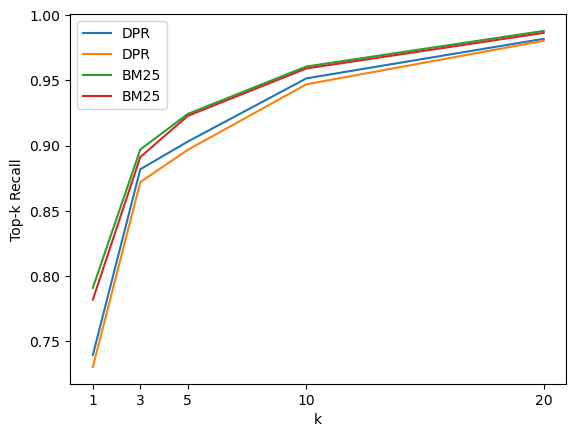

In [55]:
plot_retriever_eval([dense_topk_df,topk_df],['DPR','BM25'])

## Evaluation of Reader
1. Evalation of reader is done using two metrics a) Exact Match and b) F1-score
    - Exact match : compares the exact matches between two string i.e prediction and ground truth.
        - So it is kind of hard evaluator
    - F1 Score : calacuate by combining precision and recall socres of prediction and ground truth
            - It is soft evalator 
            - It sometimes give worng notion even if incorrect answer is given
    - Ideally there is tradeoff between these metrics to evalaute the reader efficiently
      
    - Generally the overall score is given as average of individual scores for each question-answer pair evaluation

In [56]:
#creating a reader pipeline for evaluation......
reader_pipe = Pipeline()
reader_pipe.add_node(component= reader,name="Reader",inputs=['Query'])

In [57]:
#in order to evaluate on reader we need to pass both labels and docs....
eval_docs = [[label.document for label in multi_label.labels] for multi_label in labels_agg]

In [58]:
#evaluating only on topk=1
reader_eval = reader_pipe.eval(labels=labels_agg,documents=eval_docs,params={"Reader": {"top_k":1}})

In [61]:
#prinintng metric
metrics_ = reader_eval.calculate_metrics()
print(f"Exact Matching Score on eval dataset : {metrics_['Reader']['exact_match']}")
print(f"F1  Score on eval dataset : {metrics_['Reader']['f1']}")

Exact Matching Score on eval dataset : 0.4636363636363636
F1  Score on eval dataset : 0.5164710843721538


In [63]:
#collecting metrics.....
reader_metrics = {}
reader_metrics['Finetuned on SQuAD'] = metrics_['Reader']

In [82]:
def evaluate_reader(reader,labels_agg):
    
    pipe = Pipeline()
    pipe.add_node(component=reader,name="Reader",inputs=['Query'])
    
    #eval doc 
    eval_docs = [[label.document for label in multi_label.labels] for multi_label in labels_agg]
    
    #eval reader
    eval_ = pipe.eval(labels=labels_agg,documents=eval_docs,params={"Reader": {"top_k":1}})
    #metrics 
    met = eval_.calculate_metrics()
    
    return met['Reader']

In [66]:
def plot_reader_eval(reader_eval):
    fig, ax = plt.subplots()
    df = pd.DataFrame.from_dict(reader_eval)
    df.iloc[:2,:].plot(kind="bar", ylabel="Score", rot=0, ax=ax)
    ax.set_xticklabels(["EM", "F1"])
    plt.legend(loc='upper left')
    plt.show()


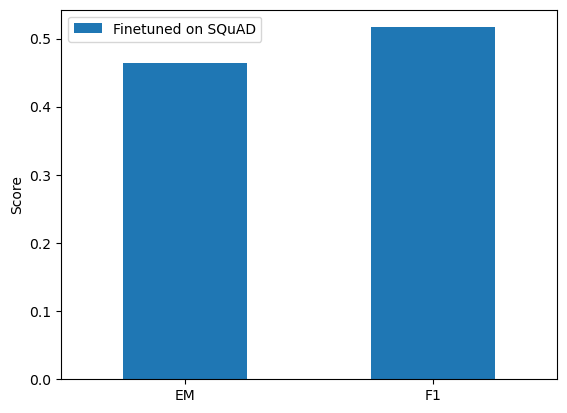

In [67]:
plot_reader_eval(reader_metrics)

## Domain Adaptation of Reader via Fine-Tuning Reader

- To train a reader in haystack it the data should be in format of json file in SQuAD dataset format

In [75]:
#creating paragraphs as per SQuAD dataset format to fine-tune reader
def create_paragraphs(df):
    
    paragraphs = []
    
    id2context = dict(zip(df["review_id"], df["context"]))
    
    for review_id, review in id2context.items():
        
        qas = []
        
        # Filter for all question-answer pairs about a specific context
        review_df = df.query(f"review_id == '{review_id}'")
        id2question = dict(zip(review_df["id"], review_df["question"]))
        
        # Build up the qas array
        for qid, question in id2question.items():
            
            # Filter for a single question ID
            question_df = df.query(f"id == '{qid}'").to_dict(orient="list")
            ans_start_idxs = question_df["answers.answer_start"][0].tolist()
            ans_text = question_df["answers.text"][0].tolist()
            
            # Fill answerable questions
            if len(ans_start_idxs):
                answers = [
                {"text": text, "answer_start": answer_start}
                for text, answer_start in zip(ans_text, ans_start_idxs)]
                
                is_impossible = False
            else:
                answers = []
                is_impossible = True
                # Add question-answer pairs to qas
            qas.append({"question": question, "id": qid,
            "is_impossible": is_impossible, "answers": answers})

        # Add context and question-answer pairs to paragraphs
        paragraphs.append({"qas": qas, "context": review})
            
    return paragraphs

In [76]:
product = dfs["train"].query("title == 'B00001P4ZH'")
create_paragraphs(product)

[{'qas': [{'question': 'How is the bass?',
    'id': '2543d296da9766d8d17d040ecc781699',
    'is_impossible': True,
    'answers': []}],
  'context': 'I have had Koss headphones in the past, Pro 4AA and QZ-99.  The Koss Portapro is portable AND has great bass response.  The work great with my Android phone and can be "rolled up" to be carried in my motorcycle jacket or computer bag without getting crunched.  They are very light and do not feel heavy or bear down on your ears even after listening to music with them on all day.  The sound is night and day better than any ear-bud could be and are almost as good as the Pro 4AA.  They are "open air" headphones so you cannot match the bass to the sealed types, but it comes close. For $32, you cannot go wrong.'},
 {'qas': [{'question': 'Is this music song have a goo bass?',
    'id': 'd476830bf9282e2b9033e2bb44bbb995',
    'is_impossible': False,
    'answers': [{'text': 'Bass is weak as expected', 'answer_start': 1302},
     {'text': 'Bass i

In [77]:
#saving them into json files...
import json

def convert_to_squad(dfs):
    for split, df in dfs.items():
        subjqa_data = {}
        # Create `paragraphs` for each product ID
        groups = (df.groupby("title").apply(create_paragraphs)
            .to_frame(name="paragraphs").reset_index())
        subjqa_data["data"] = groups.to_dict(orient="records")
        # Save the result to disk
        with open(f"electronics-{split}.json", "w+", encoding="utf-8") as f:
            json.dump(subjqa_data, f)
            
convert_to_squad(dfs)
     

In [81]:
#training the reader....
train_filename = "electronics-train.json"
dev_filename = "electronics-validation.json"
reader.train(data_dir=".",use_gpu=True,n_epochs=1, batch_size=4,train_filename=train_filename, dev_filename=dev_filename)

Preprocessing dataset:   0%|          | 0/3 [00:00<?, ? Dicts/s]Answer 'These earbuds are nothing special. Their best attribute is that they are cheap. The sound from them is nothing special. In comparison to my standard white IPod buds these seem to emphasize the higher frequencies. There seems to be nothing happening in the bass range with these. I don't think they are efficient enough to have much bass at all. To be fair, my IPod buds overly emphasize bass so they are not that accurate either. I also compared these to a pricy Sennheiser set that I've owned for a couple of years and let's just say there is a reason why the Sennheisers cost more.Surely these Panasonic buds are very nice to use if you think they might get damaged somehow in use as it will not break your heart to have to replace them. These might be especially useful if you only listen to talk radio or have high frequency hearing loss. If you really like to listen to the most of your music and you must wear earbuds then

In [83]:
ft_farm = evaluate_reader(reader=reader,labels_agg=labels_agg)

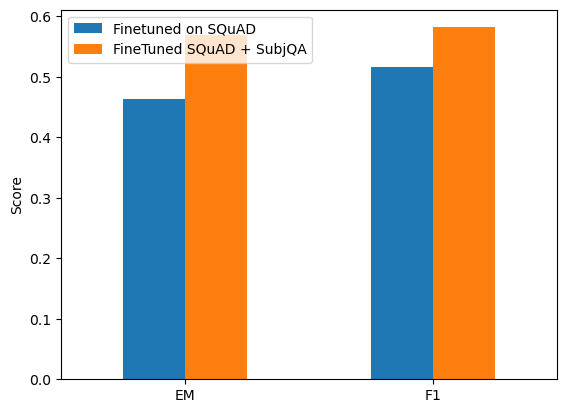

In [86]:
reader_metrics['FineTuned SQuAD + SubjQA'] = ft_farm

plot_reader_eval(reader_metrics)

In [88]:
#try to build model only finetuned on SubjQA dataset....
minilm_ckpt = "microsoft/MiniLM-L12-H384-uncased"

minilm_reader = FARMReader(model_name_or_path=minilm_ckpt, progress_bar=False,
max_seq_len=max_seq_length, doc_stride=doc_stride,return_no_answer=True)


Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at microsoft/MiniLM-L12-H384-uncased and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [94]:
#fine-tuning reader on SujbQA dataset....
minilm_reader.train(data_dir='.',use_gpu=True,n_epochs=1,batch_size=1,train_filename=train_filename, dev_filename=dev_filename,grad_acc_steps=16)

Preprocessing dataset:   0%|          | 0/3 [00:00<?, ? Dicts/s]Answer 'These earbuds are nothing special. Their best attribute is that they are cheap. The sound from them is nothing special. In comparison to my standard white IPod buds these seem to emphasize the higher frequencies. There seems to be nothing happening in the bass range with these. I don't think they are efficient enough to have much bass at all. To be fair, my IPod buds overly emphasize bass so they are not that accurate either. I also compared these to a pricy Sennheiser set that I've owned for a couple of years and let's just say there is a reason why the Sennheisers cost more.Surely these Panasonic buds are very nice to use if you think they might get damaged somehow in use as it will not break your heart to have to replace them. These might be especially useful if you only listen to talk radio or have high frequency hearing loss. If you really like to listen to the most of your music and you must wear earbuds then

In [95]:
minilm_eval = evaluate_reader(minilm_reader,labels_agg)

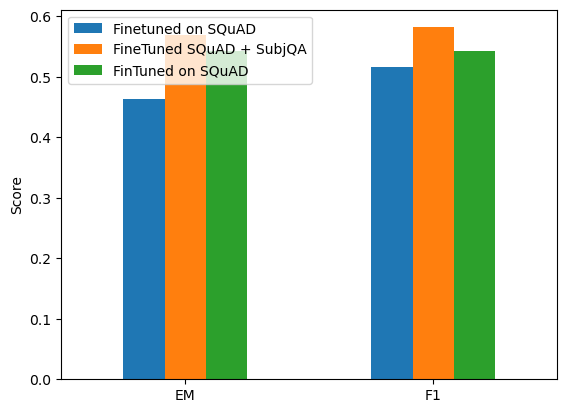

In [96]:
reader_metrics['FinTuned on SQuAD'] = minilm_eval

plot_reader_eval(reader_metrics)

## Evalauting on whole QA system.....

In [99]:
#creating  new pipeline for evaluating individual and whole retrieval system...
qa_pipe = Pipeline()
qa_pipe.add_node(component=sparse_retriever,name='Retriever',inputs=['Query'])
qa_pipe.add_node(component=reader,name="Reader",inputs=['Retriever'])

In [101]:
#evalating whole pipeline
qa_eval = qa_pipe.eval(labels=labels_agg,params={'Reader':{"top_k" : 1}})

#metrics..
qa_metric = qa_eval.calculate_metrics()

In [102]:
qa_metric

{'Retriever': {'recall_multi_hit': 0.9590909090909091,
  'recall_single_hit': 0.9606060606060606,
  'precision': 0.727029822029822,
  'map': 0.8474843674843674,
  'mrr': 0.8481890331890332,
  'ndcg': 0.8754889506436367},
 'Reader': {'exact_match': 0.5242424242424243,
  'f1': 0.5494306613839403,
  'num_examples_for_eval': 330.0}}

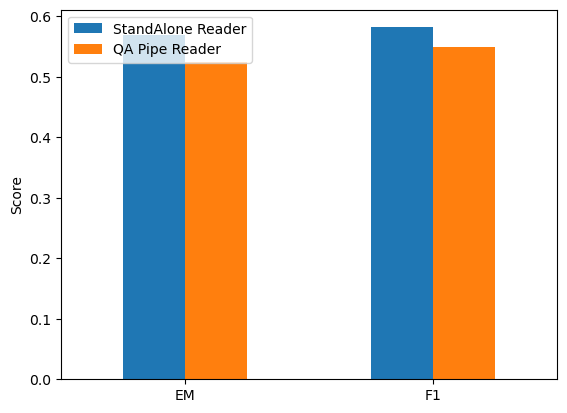

In [103]:
#plotting metrics...
plot_reader_eval({"StandAlone Reader":reader_metrics['FineTuned SQuAD + SubjQA'],
                  "QA Pipe Reader" : qa_metric['Reader']})

# Retrieval Augmented Generation

- Instead of extracting answers from a span of text, generating answers using a pre-trained model/answer spanning across documents is called Generative QA
- RAG is system where normal retriver-reader architecture is replaced by retriever-generator arch
        - Generator : the reader is replaced by Generator which consists of pre-trained models like T5,BART
        - Retriever : typically Desne Passage Retriever are used so rich embeddings can be used
        
- Two types of RAG models :
    - RAG-Sequence :Uses the same retrieved document to generate the complete answer. In particular,the top k documents from the retriever are fed to the generator, which producesan output sequence for each document, and the result is marginalized to obtainthe best answer.
    - RAG-Token : Can use a different document to generate each token in the answer. This allows the generator to synthesize evidence from multiple documents.

In [111]:
#instantiaing generator
from haystack.nodes import RAGenerator
from haystack.pipelines import ExtractiveQAPipeline

In [113]:
#generator...
geneator = BaseGenerator(model_name_or_path="facebook/rag-token-nq",embed_title=False, num_beams=5)

In [114]:
#instantiating pipeline...
pipe = GenerativeQAPipeline(generator=generator, retriever=dpr_retriever)

In [ ]:
#generating answer
def generate_answers(query, top_k_generator=3):
    preds = pipe.run(query=query, 
                     params={"Retriever": {"top_k":5, 
                                  "filters":{"item_id": ["B0074BW614"]}},
                             "Generator": {"top_k": top_k_generator}})  
    print(f"Question: {preds['query']} \n")
    for idx in range(top_k_generator):
        print(f"Answer {idx+1}: {preds['answers'][idx].answer}")

In [ ]:
generate_answers(query)

In [ ]:
generate_answers("What is the main drawback?")